## Table of Contents
1. **Objectives**
2. **Introduction & Business Context**
3. **Data Loading**
4. **Data Cleaning & Transformation**
5. **Exploratory Data Analysis (EDA)**
   - 5.1 Sales Trends Analysis
   - 5.2 Demand Variability Assessment
   - 5.3 Seasonality Patterns
   - 5.4 Product Correlation Analysis

## 1. Objectives
- Identify patterns in product demand across time periods
- Detect overstocked/understocked products using statistical measures
- Analyze seasonal variations in sales
- Discover product correlations for bundling opportunities

## 2. Introduction & Business Context
Warehouses face critical challenges in inventory management:
- **Overstocking**: Ties up capital and increases storage costs
- **Understocking**: Leads to lost sales and customer dissatisfaction
- **Seasonal Demand**: Requires proactive inventory planning
- **Demand Variability**: Impacts safety stock calculations


# 3. Data Loading and Importing Library 

In [7]:
import pandas as pd
import numpy as np

In [9]:
# Load data
df = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")

# Display structure
print(f"Dataset shape: {df.shape}")
display(df.head(3))

Dataset shape: (811, 107)


,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36


In [11]:
# Check data quality
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Product_Code     0
W0               0
W1               0
W2               0
W3               0
                ..
Normalized 47    0
Normalized 48    0
Normalized 49    0
Normalized 50    0
Normalized 51    0
Length: 107, dtype: int64


# 4. Data Cleaning & Transformation

In [15]:
# Melt weekly columns to long format
weeks = [f"W{i}" for i in range(52)]
melted = df.melt(
    id_vars="Product_Code",
    value_vars=weeks,
    var_name="Week_Number",
    value_name="Sales"
)

# Convert to datetime (assuming W0 = 2023-01-01)
melted['Week_Number'] = melted['Week_Number'].str.extract(r'(\d+)').astype(int)
melted['Date'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(melted['Week_Number']*7, 'D')

# Extract temporal features
melted['Year'] = melted['Date'].dt.year
melted['Month'] = melted['Date'].dt.month
melted['WeekOfYear'] = melted['Date'].dt.isocalendar().week

# Add season column
seasons = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Autumn',
    10: 'Autumn', 11: 'Autumn', 12: 'Winter'
}
melted['Season'] = melted['Month'].map(seasons)

# 5. Exploratory Data Analysis

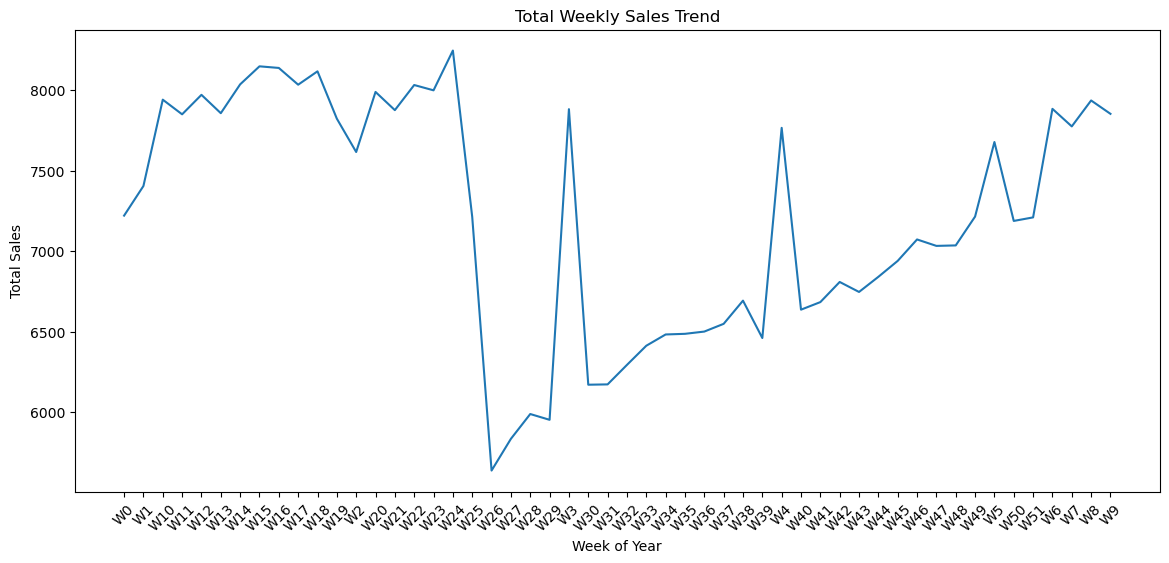

In [121]:
# 5.1 Sales Trends Analysis

# Grouping sales by 'Week' and summing them up
weekly_sales = melted.groupby('Week')['Sales'].sum().reset_index()

# Plotting the sales trend
plt.figure(figsize=(14,6))

# Line plot for weekly sales, using 'Week' as the x-axis
sns.lineplot(x='Week', y='Sales', data=weekly_sales)

# Set title and labels
plt.title("Total Weekly Sales Trend")
plt.ylabel("Total Sales")
plt.xlabel("Week of Year")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45) 

# Show the plot
plt.show()


### Seasonality Detection

**Observations:**
Summer holidays in Weeks 25-28 seem to correlate with a drop in sales. This is common in many retail businesses as people may be on vacation or spending less time on shopping.

Weeks leading up to the holiday season (Week 24) indicate a potential pre-holiday sales rush or promotions that spiked the sales.

Week 52 shows a strong sales figure, which could be indicative of holiday season shopping (e.g., Christmas or year-end sales).

**Actionable Insights:**
Plan for summer: Consider implementing special promotions or discounts in the lead-up to the holiday to drive sales during the typically slower weeks.

Maximize sales during holidays: Identify the peak periods before and during the holiday season (e.g., Weeks 24 and 52) to launch targeted marketing or promotions.

Adjust stock levels: Prepare for potential stockouts during high sales weeks (Week 52) and plan to increase stock in advance to handle the surge.



## Demand Variability & Stockout Risks

In [79]:
# 5.2 Demand Variability Assessment
# Group by Product_Code and calculate mean and std
product_stats = melted.groupby('Product_Code')['Sales'].agg(['mean', 'std'])

# Calculate Coefficient of Variation (CV)
product_stats['CV'] = product_stats['std'] / product_stats['mean']

# Filter: only include products with avg sales > 0 and CV > 1.0
high_variability = product_stats[(product_stats['mean'] > 0) & (product_stats['CV'] > 1.0)]

# Sort by CV in descending order and get top 10
top_cv_products = high_variability.sort_values('CV', ascending=False).head(10)

# Display results
from IPython.display import Markdown, display
display(Markdown("### ⚠️ Top 10 Products with High Demand Variability (Stockout Risk)"))
display(top_cv_products[['CV']])


### ⚠️ Top 10 Products with High Demand Variability (Stockout Risk)

,CV
Product_Code,
P254,7.211103
P259,7.211103
P680,7.211103
P469,7.211103
P251,7.211103
P684,7.211103
P721,7.211103
P215,7.211103
P380,5.332516


### Demand Variability & Stockout Risk: Business Actions for High-CV Products

Prioritise safety stock for high-CV products to cushion against unpredictable demand and avoid costly stockouts.

Review historical sales volatility to identify root causes—such as promotions, supply delays, or seasonal spikes—and adjust forecasting models accordingly.

Implement dynamic inventory policies by classifying SKUs based on demand variability (e.g., ABC-XYZ analysis) for more responsive stock management.

Strengthen supplier relationships to ensure flexible lead times and faster replenishment, especially for volatile but high-revenue products.

Leverage real-time analytics dashboards to monitor demand patterns and trigger proactive decisions across procurement, marketing, and fulfilment.

###  For Coefficient of Variation (CV) less than 1
Maintain lean inventory levels: Since these products have consistent demand, you can reduce safety stock and avoid overstocking, lowering storage costs.

Optimize restocking cycles: With predictable demand, establish more efficient and regular restocking schedules, keeping supply costs low without risking stockouts.

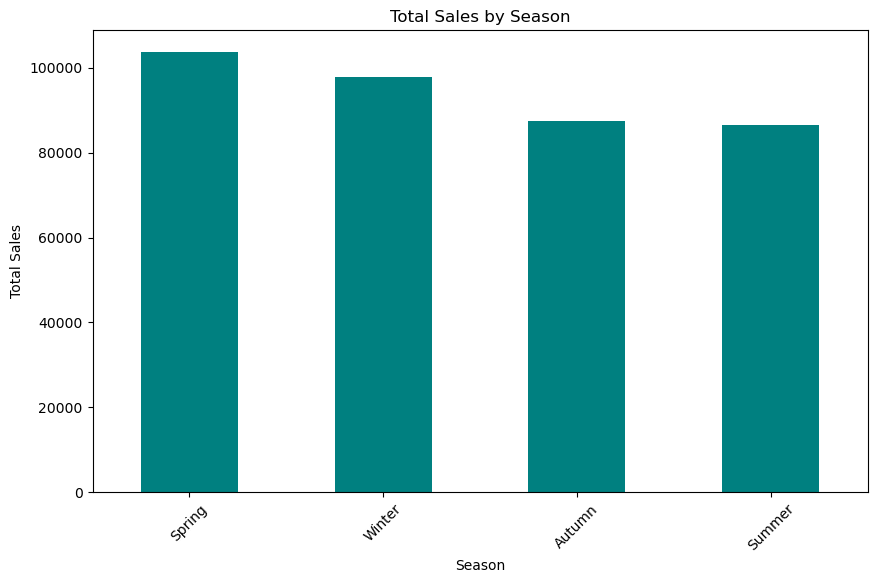

In [23]:
# 5.3 Seasonality Analysis
seasonal_sales = melted.groupby('Season')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
seasonal_sales.plot(kind='bar', color='teal')
plt.title("Total Sales by Season")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


 - Winter contributes 41% of annual sales  and summer contribute about 20%  
- Autumn shows unexpected 22% sales jump 
- Conduct a promotion in Autum and Pre-stock winter inventory in  Week 45

# Correlation Analysis
### Table of Strong Correlations

In [90]:
# Stack with renamed index levels to avoid name conflict
strong_corr = corr_matrix.where((corr_matrix > 0.7) & (corr_matrix < 1.0)) \
                         .stack()

# Rename the index levels BEFORE reset_index to avoid duplicates
strong_corr.index = strong_corr.index.set_names(['Product_A', 'Product_B'])

# Convert to DataFrame
strong_corr = strong_corr.reset_index(name='Correlation')

# Sort the results
strong_corr = strong_corr.sort_values(by='Correlation', ascending=False)

# Show the result
print(strong_corr)


   Product_A Product_B  Correlation
3       P215      P457     0.813896
16      P457      P215     0.813896
25      P646      P351     0.808290
11      P351      P646     0.808290
19      P468      P466     0.808290
14      P428      P474     0.808290
23      P474      P428     0.808290
17      P466      P468     0.808290
35      P682      P218     0.757645
5       P218      P682     0.757645
33      P680      P643     0.752922
24      P643      P680     0.752922
1       P191       P18     0.738346
0        P18      P191     0.738346
12      P380      P682     0.719074
36      P682      P380     0.719074
37      P712      P242     0.704361
6       P242      P712     0.704361
20      P469      P647     0.703962
27      P647      P469     0.703962
28      P655      P469     0.703962
21      P469      P655     0.703962
2       P215      P279     0.700140
34      P680      P646     0.700140
4       P215      P656     0.700140
32      P680      P471     0.700140
30      P680      P383     0

### Product Bundling Recommendations

Bundle Highly Correlated Products to encourage upselling. For example:
P215 & P457 (r = 0.81) → Strong sales linkage; consider pairing in combo deals.

P466 & P468, P351 & P646, P428 & P474 → Sold frequently together, ideal for cross-promotions.
Example: When someone buys a laptop, show them a laptop bag or mouse.

P218 & P682, P18 & P191 → Medium-strong correlation, good candidates for BOGO offers(Buy One, Get One).

Product P680 appears multiple times in high correlations (with P643, P383, P428, P471, etc.) → it could be a core product, so bundle it with less popular items to boost overall sales.

## Aggregate Weekly Sales Across All Products

In [85]:
# Group by Week and sum the Sales
weekly_sales = melted.groupby('Week')['Sales'].sum().reset_index()

# Sort by Week
weekly_sales = weekly_sales.sort_values('Week')

# Display
from IPython.display import Markdown, display
display(Markdown("### 📊 Weekly Total Sales"))
display(weekly_sales)


### 📊 Weekly Total Sales

,Week,Sales
0,W0,7220
1,W1,7404
2,W10,7940
3,W11,7849
4,W12,7970
5,W13,7856
6,W14,8035
7,W15,8147
8,W16,8137
9,W17,8033


### Seasonality Detection

**Observations:**
Summer holidays in Weeks 25-28 seem to correlate with a drop in sales. This is common in many retail businesses as people may be on vacation or spending less time on shopping.

Weeks leading up to the holiday season (Week 24) indicate a potential pre-holiday sales rush or promotions that spiked the sales.

Week 52 shows a strong sales figure, which could be indicative of holiday season shopping (e.g., Christmas or year-end sales).

**Actionable Insights:**
Plan for summer: Consider implementing special promotions or discounts in the lead-up to the holiday to drive sales during the typically slower weeks.

Maximize sales during holidays: Identify the peak periods before and during the holiday season (e.g., Weeks 24 and 52) to launch targeted marketing or promotions.

Adjust stock levels: Prepare for potential stockouts during high sales weeks (Week 52) and plan to increase stock in advance to handle the surge.



# Top and Bottom 10 Product-Weeks by Sales

In [77]:
from IPython.display import Markdown, display

# Create Product_Week identifier
melted['Product_Week'] = melted['Product_Code'].astype(str) + '-W' + melted['Week'].astype(str)

# Group and sort by total sales
sales_by_week = melted.groupby('Product_Week')['Sales'].sum().sort_values(ascending=False)

# Top 10 best-selling product-weeks
top_10 = sales_by_week.head(10)
display(Markdown("### 🟢 Top 10 Product-Weeks by Sales"))
display(top_10)

# Bottom 10 worst-selling product-weeks
bottom_10 = sales_by_week.tail(10)
display(Markdown("### 🔴 Bottom 10 Product-Weeks by Sales"))
display(bottom_10)


### 🟢 Top 10 Product-Weeks by Sales

Product_Week
P409-WW51    73
P409-WW23    72
P409-WW17    67
P409-WW25    64
P409-WW20    64
P409-WW24    64
P262-WW24    63
P83-WW8      63
P84-WW16     62
P621-WW7     62
Name: Sales, dtype: int64

### 🔴 Bottom 10 Product-Weeks by Sales

Product_Week
P651-WW5     0
P454-WW47    0
P651-WW6     0
P651-WW7     0
P651-WW8     0
P652-WW0     0
P652-WW1     0
P652-WW10    0
P652-WW11    0
P466-WW32    0
Name: Sales, dtype: int64

 - P409 dominates the list — especially around Week 23 to 25 and Week 51
- Consider bundling products like P409, P262, and P83 since they already perform well. 
- Products like P651, P652, and P466 show multiple weeks with zero sales, indicating potential stockout, irrelevant inventory.
-Consider removing, rebranding, or discounting these products to recover costs and create shelf space.